python -m venv store_forcast
pip install --upgrade cython
pip install pystan==2.17.1 #2.19.1.1
pip install statsmodels==0.12.2
pip install kats

https://github.com/facebookresearch/Kats/blob/main/tutorials/kats_201_forecasting.ipynb
https://www.kaggle.com/code/luisblanche/look-what-the-kats-dragged-in



https://www.kaggle.com/code/loicge/sales-top-down-approach-with-prophet-0-52#6.-Top-down-approach-with-Prophet

# Sales - Top down approach with Prophet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from datetime import datetime, timedelta
from tqdm import tqdm
from pathlib import Path
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import os
DIR = Path('./data/')

In [6]:
train = pd.read_csv(DIR / 'train.csv')
test = pd.read_csv(DIR / 'test.csv')
stores = pd.read_csv(DIR / 'stores.csv')
oil = pd.read_csv(DIR / 'oil.csv')
transactions =  pd.read_csv(DIR / 'transactions.csv').sort_values(["store_nbr", "date"])
holidays = pd.read_csv(DIR / 'holidays_events.csv')

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
oil["date"] = pd.to_datetime(oil.date)
holidays["date"] = pd.to_datetime(holidays.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

In [7]:
class suppress_stdout_stderr(object):
    '''
   A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])
        
def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
                
    return round(metric, 4)

In [8]:
train_df, test_df = train, test
train_df

id       date  store_nbr                      family  \
0              0 2013-01-01          1                  AUTOMOTIVE   
1              1 2013-01-01          1                   BABY CARE   
2              2 2013-01-01          1                      BEAUTY   
3              3 2013-01-01          1                   BEVERAGES   
4              4 2013-01-01          1                       BOOKS   
...          ...        ...        ...                         ...   
3000883  3000883 2017-08-15          9                     POULTRY   
3000884  3000884 2017-08-15          9              PREPARED FOODS   
3000885  3000885 2017-08-15          9                     PRODUCE   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   
3000887  3000887 2017-08-15          9                     SEAFOOD   

               sales  onpromotion  
0           0.000000          0.0  
1           0.000000          0.0  
2           0.000000          0.0  
3           0.000000          0.0  
4           0.000000          0.0  
...              ...          ...  
3000883   438.132996          0.0  
3000884   154.552994          1.0  
3000885  2419.729004        148.0  
3000886   121.000000          8.0  
3000887    16.000000          0.0  

[3000888 rows x 6 columns]

In [9]:

train_df = train_df.assign(last_year_ds = train_df.date - timedelta(days=52*7))
train_df = pd.merge(train_df, 
                         train_df[['date', 'store_nbr', 'family', 'sales']], 
                         left_on=['last_year_ds', 'store_nbr', 'family'], 
                         right_on=['date', 'store_nbr', 'family']).rename(columns={'date_x': 'date', 'sales_x': 'sales', 'sales_y': 'yhat'})


In [10]:
train_df

id       date  store_nbr                      family  \
0         646866 2013-12-31          1                  AUTOMOTIVE   
1         646867 2013-12-31          1                   BABY CARE   
2         646868 2013-12-31          1                      BEAUTY   
3         646869 2013-12-31          1                   BEVERAGES   
4         646870 2013-12-31          1                       BOOKS   
...          ...        ...        ...                         ...   
2348671  3000883 2017-08-15          9                     POULTRY   
2348672  3000884 2017-08-15          9              PREPARED FOODS   
2348673  3000885 2017-08-15          9                     PRODUCE   
2348674  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   
2348675  3000887 2017-08-15          9                     SEAFOOD   

               sales  onpromotion last_year_ds     date_y         yhat  
0           2.000000          0.0   2013-01-01 2013-01-01     0.000000  
1           0.000000          0.0   2013-01-01 2013-01-01     0.000000  
2           1.000000          0.0   2013-01-01 2013-01-01     0.000000  
3         840.000000          0.0   2013-01-01 2013-01-01     0.000000  
4           0.000000          0.0   2013-01-01 2013-01-01     0.000000  
...              ...          ...          ...        ...          ...  
2348671   438.132996          0.0   2016-08-16 2016-08-16   474.641998  
2348672   154.552994          1.0   2016-08-16 2016-08-16   103.748001  
2348673  2419.729004        148.0   2016-08-16 2016-08-16  2360.931885  
2348674   121.000000          8.0   2016-08-16 2016-08-16    12.000000  
2348675    16.000000          0.0   2016-08-16 2016-08-16    17.000000  

[2348676 rows x 9 columns]

In [11]:
#Cross validation
val_df = train_df[(train_df.date>= '2017-08-01') & (train_df.date <= '2017-08-15')]
print('RMSLE: %s' %rmsle(val_df.yhat, val_df.sales))

RMSLE: 0.9495


In [12]:
test_df = test_df.assign(last_year_ds = test_df.date - timedelta(days=52*7))
submission_df = pd.merge(test_df, 
                         train_df[['date', 'store_nbr', 'family', 'sales']], 
                         left_on=['last_year_ds', 'store_nbr', 'family'], 
                         right_on=['date', 'store_nbr', 'family'])[['id', 'sales']]

submission_df

id        sales
0      3000888     4.000000
1      3000889     0.000000
2      3000890     3.000000
3      3000891  2346.000000
4      3000892     0.000000
...        ...          ...
28507  3029395   406.360992
28508  3029396   125.994003
28509  3029397  1385.166016
28510  3029398    38.000000
28511  3029399    13.877000

[28512 rows x 2 columns]

In [13]:
train_df, test_df = train, test
if 'sales' in train_df.columns:
    train_df = train_df.rename(columns={'sales': 'y'})
if 'date' in train_df.columns:
    train_df = train_df.rename(columns={'date': 'ds'})
train_df       # Rename columns to prophet standards

id         ds  store_nbr                      family  \
0              0 2013-01-01          1                  AUTOMOTIVE   
1              1 2013-01-01          1                   BABY CARE   
2              2 2013-01-01          1                      BEAUTY   
3              3 2013-01-01          1                   BEVERAGES   
4              4 2013-01-01          1                       BOOKS   
...          ...        ...        ...                         ...   
3000883  3000883 2017-08-15          9                     POULTRY   
3000884  3000884 2017-08-15          9              PREPARED FOODS   
3000885  3000885 2017-08-15          9                     PRODUCE   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   
3000887  3000887 2017-08-15          9                     SEAFOOD   

                   y  onpromotion  
0           0.000000          0.0  
1           0.000000          0.0  
2           0.000000          0.0  
3           0.000000          0.0  
4           0.000000          0.0  
...              ...          ...  
3000883   438.132996          0.0  
3000884   154.552994          1.0  
3000885  2419.729004        148.0  
3000886   121.000000          8.0  
3000887    16.000000          0.0  

[3000888 rows x 6 columns]

In [14]:
def plot_multi_ts(df, feature, n_cols=6, run_forecast=False, ds_range=None, periods=None, days_to_plot=None):
    
    group_by_store_df = df.groupby(['ds'] + [feature]).agg({'y': 'sum'}).reset_index()
    stores = list(set(group_by_store_df[feature]))
    n_rows = int(len(stores)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 40))
    
    k = 0
    forecasts = []
    for i in tqdm(range(n_rows)):
        for j in range(n_cols):
            ts = group_by_store_df[group_by_store_df[feature] == stores[k]]
            
            if run_forecast:
                df = ts[['ds', 'y']]
                df = df[(df.ds >= ds_range[0]) & (df.ds <= ds_range[1])]
        
                with suppress_stdout_stderr():
                    m = Prophet()
                    m.fit(df)
                    future = m.make_future_dataframe(periods=periods)
                    forecast = m.predict(future)
                
                kwargs = {feature: lambda x: stores[k]}
                forecast = forecast.assign(**kwargs).rename(columns={'yhat': 'yhat_'  + feature})
                forecasts.append(forecast)
                ax[i][j].plot(ts[-days_to_plot:].ds, ts[-days_to_plot:].y)
                ax[i][j].plot(forecast[-periods:].ds, forecast[-periods:][['yhat_'  + feature]])
            else:
                ax[i][j].plot(ts.ds, ts.y)
            
            ax[i][j].set_title(feature + ": " + str(stores[k]), size=16)
            k += 1
    
    if run_forecast:
        forecast_per_feature = pd.concat(forecasts, axis=0)
        forecast_per_feature = pd.merge(group_by_store_df.rename(columns={'y': 'y_' + feature}), forecast_per_feature[['ds', 'yhat_' + feature] + [feature]], on=['ds'] + [feature], how='left')
    
        return forecast_per_feature

100%|██████████| 9/9 [00:00<00:00, 80.38it/s]


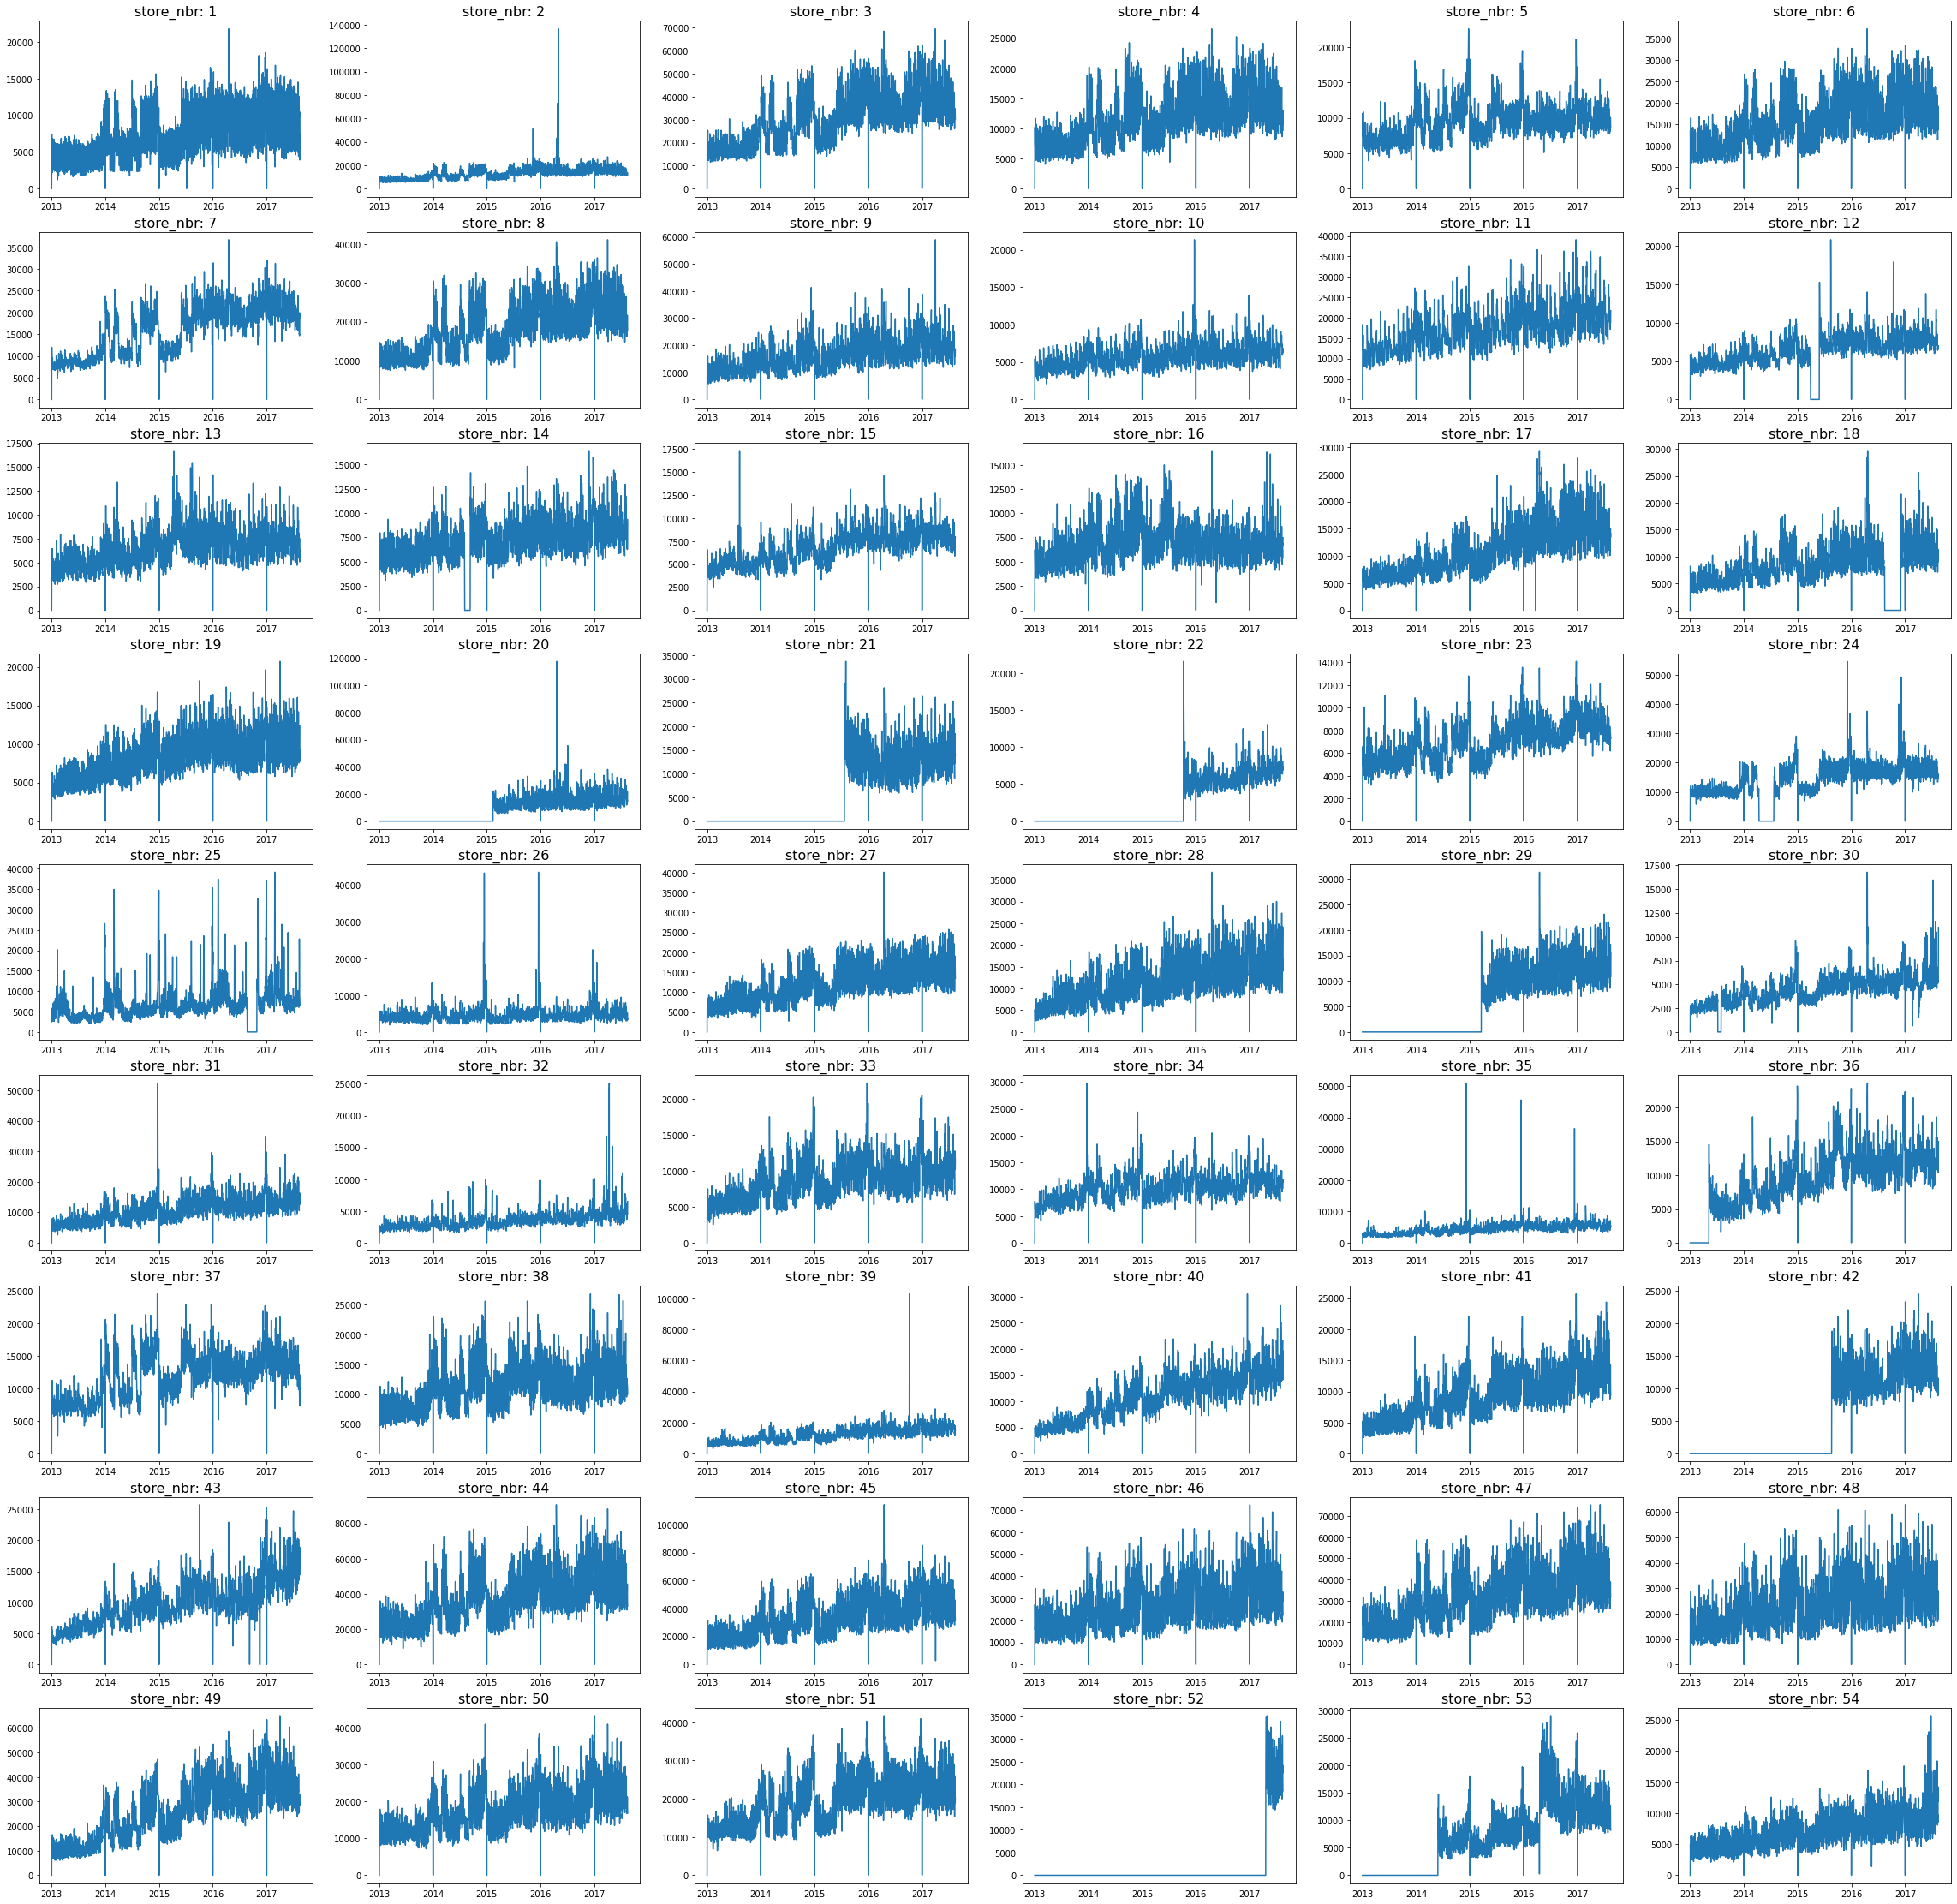

In [15]:
plot_multi_ts(train_df, 'store_nbr', run_forecast=False)

  0%|          | 0/9 [00:00<?, ?it/s]13:44:15 - cmdstanpy - INFO - Chain [1] start processing
13:44:16 - cmdstanpy - INFO - Chain [1] done processing
13:44:17 - cmdstanpy - INFO - Chain [1] start processing
13:44:17 - cmdstanpy - INFO - Chain [1] done processing
13:44:18 - cmdstanpy - INFO - Chain [1] start processing
13:44:18 - cmdstanpy - INFO - Chain [1] done processing
13:44:19 - cmdstanpy - INFO - Chain [1] start processing
13:44:19 - cmdstanpy - INFO - Chain [1] done processing
13:44:20 - cmdstanpy - INFO - Chain [1] start processing
13:44:21 - cmdstanpy - INFO - Chain [1] done processing
13:44:21 - cmdstanpy - INFO - Chain [1] start processing
13:44:22 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:07<00:59,  7.47s/it]13:44:23 - cmdstanpy - INFO - Chain [1] start processing
13:44:23 - cmdstanpy - INFO - Chain [1] done processing
13:44:24 - cmdstanpy - INFO - Chain [1] start processing
13:44:24 - cmdstanpy - INFO - Chain [1] done processing
13:44:25 - cmd

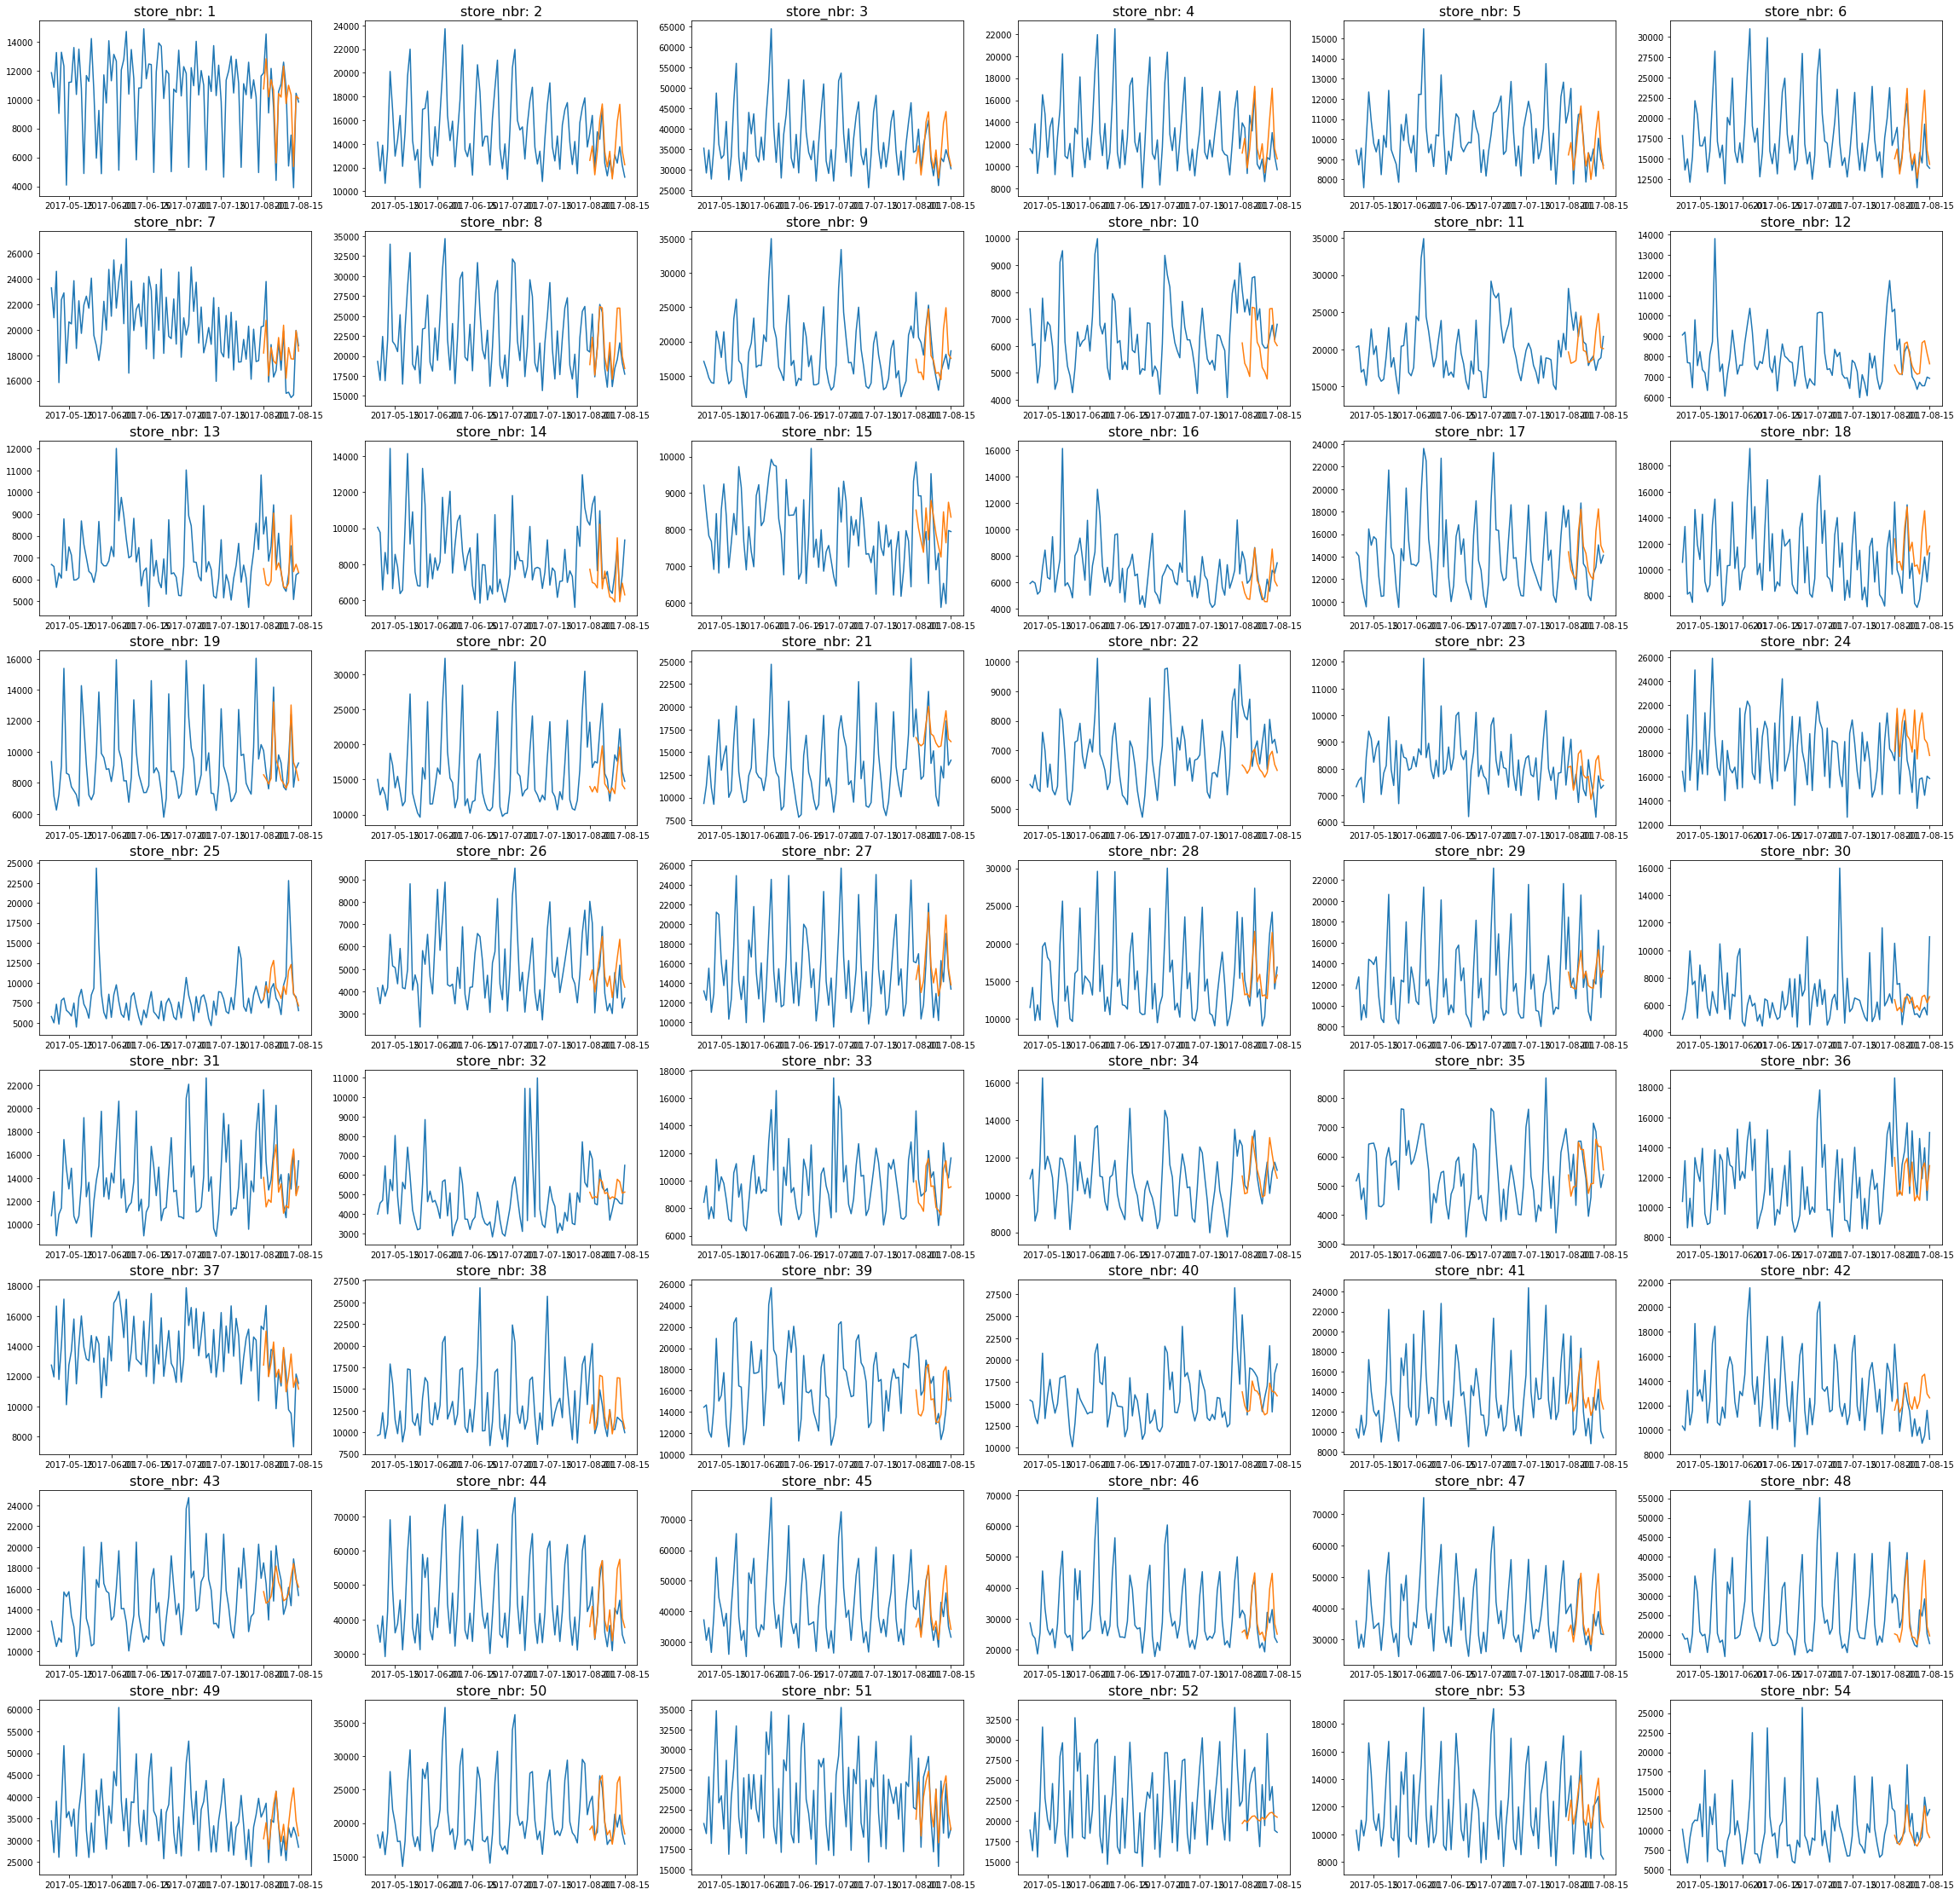

In [16]:
# Training period
ds_range = ['2013-01-01', '2017-07-31']
periods = 15
days_to_plot = 100

forecast_per_store = plot_multi_ts(train_df, 'store_nbr', run_forecast=True, ds_range=ds_range, periods=periods, days_to_plot=days_to_plot)

# Forecast family proportions for each store¶


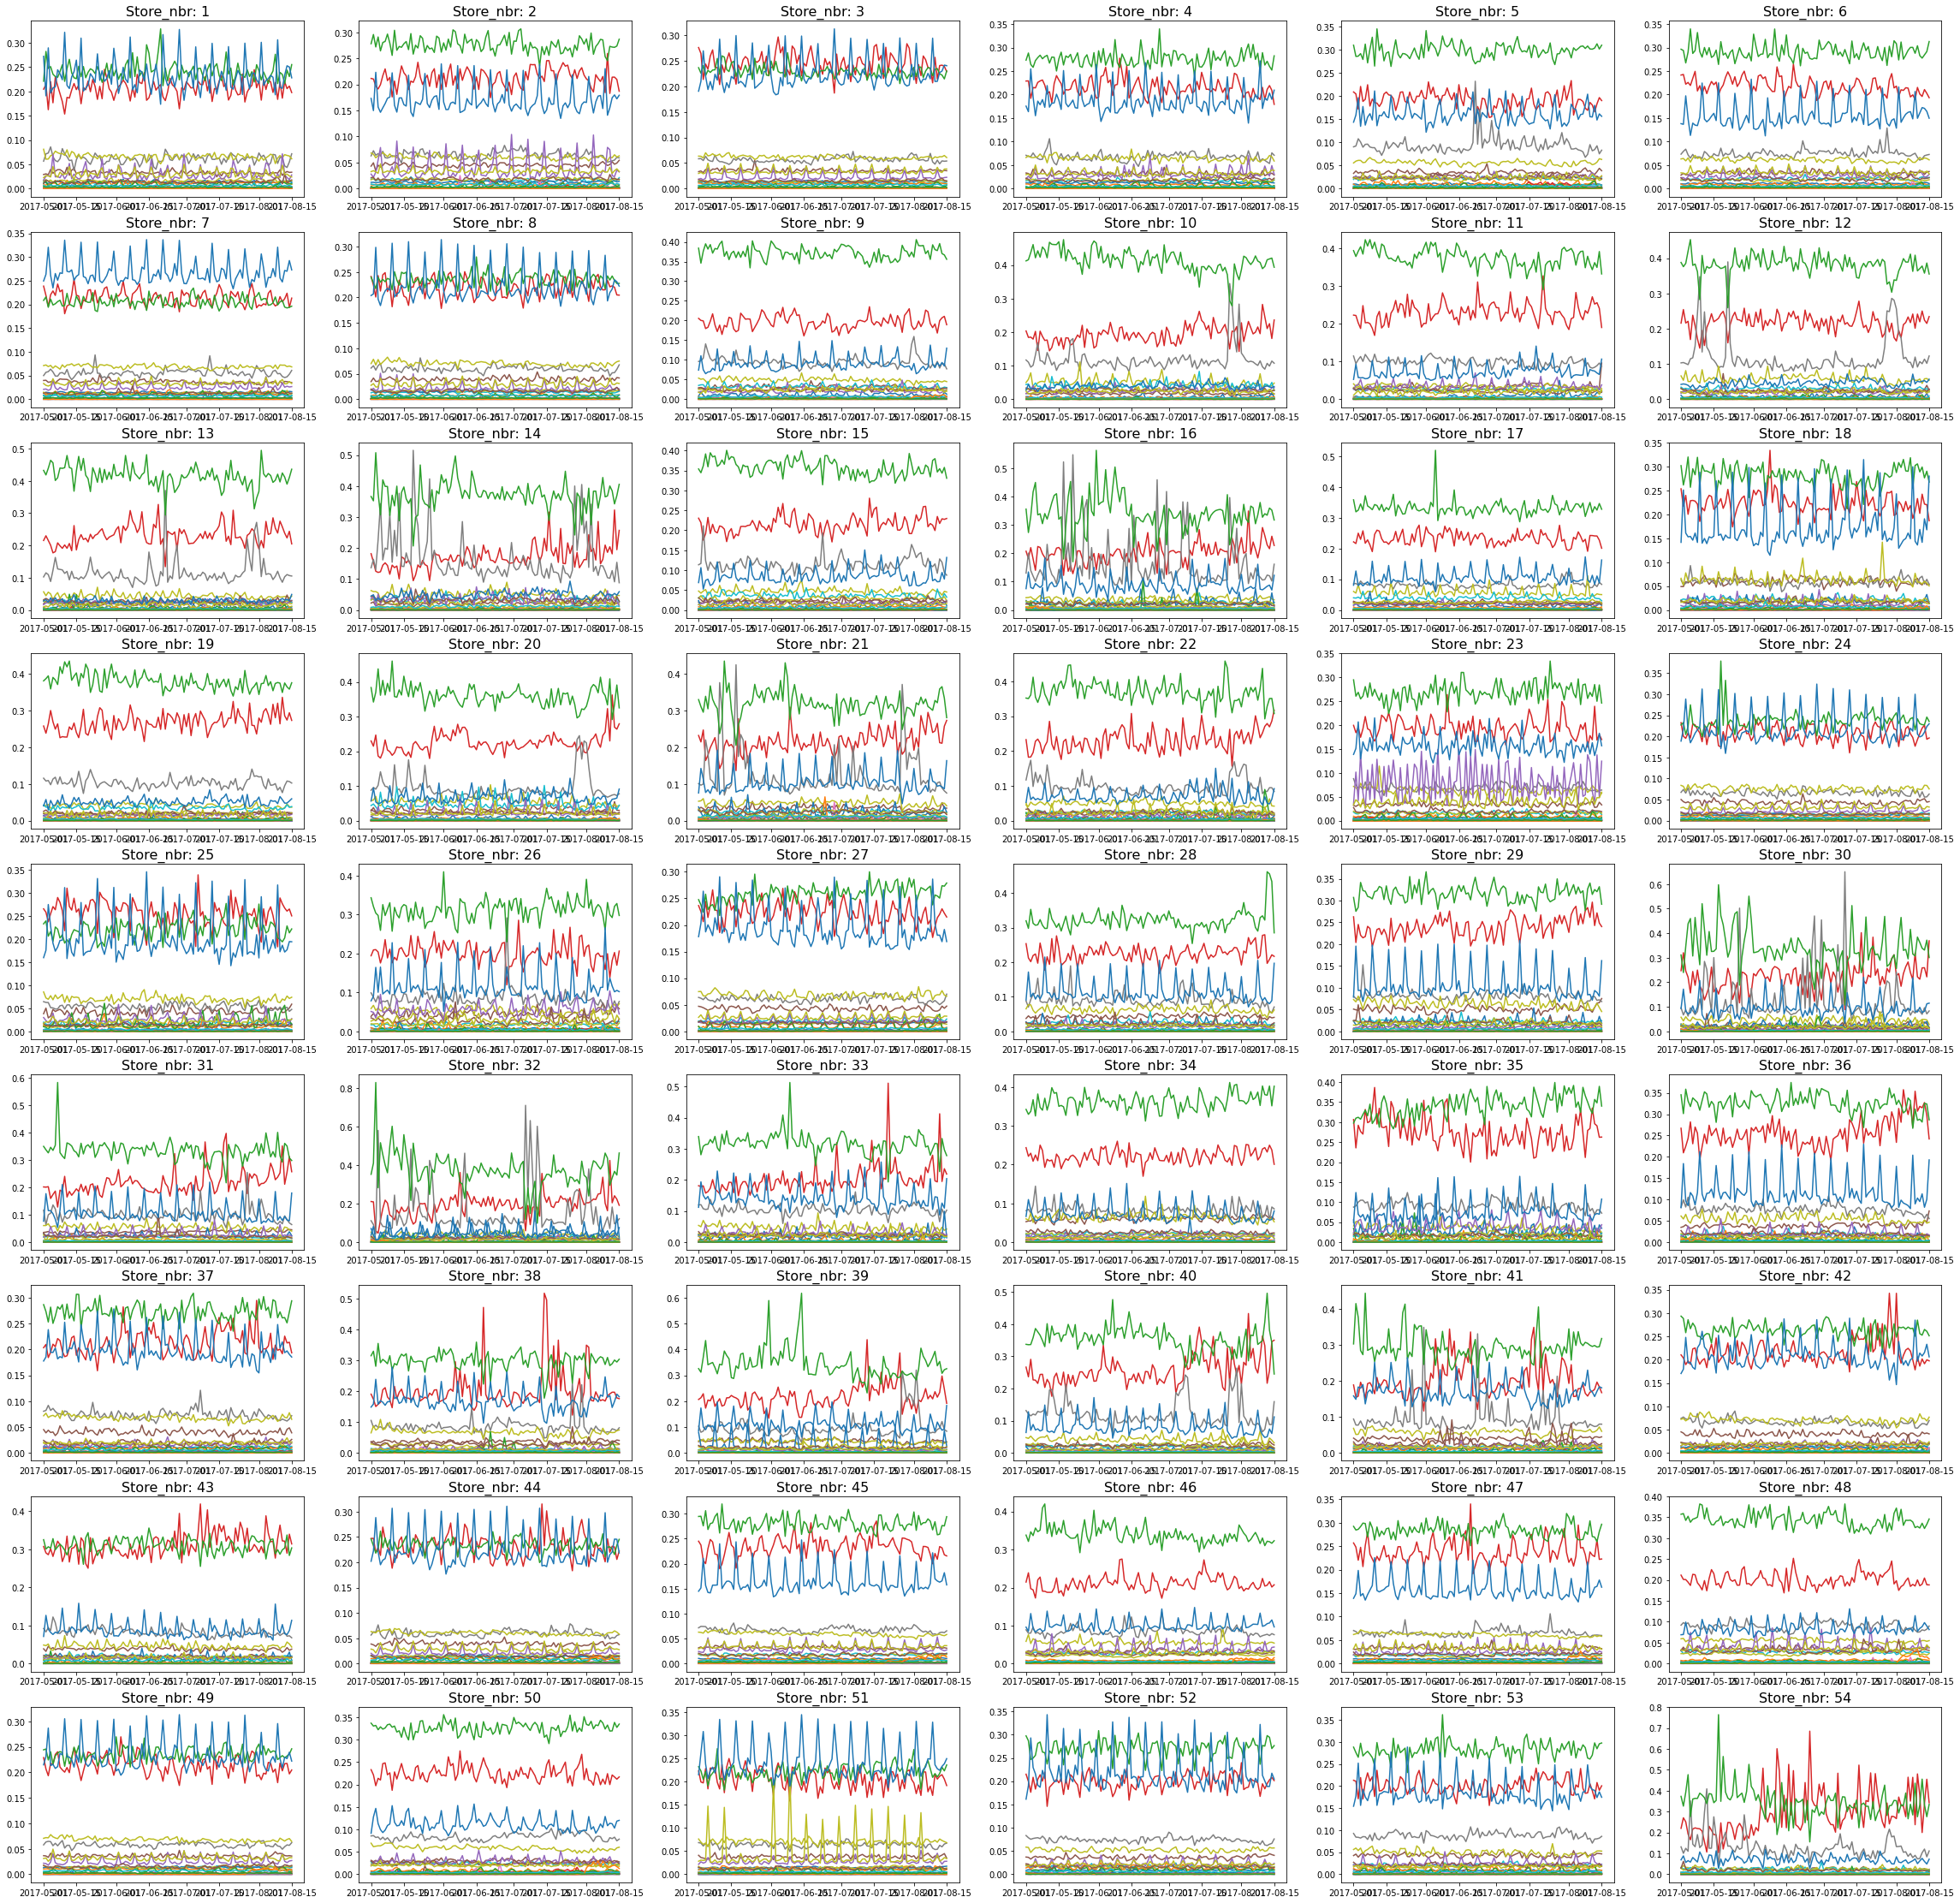

In [17]:
df = train_df
df = pd.merge(df, forecast_per_store, on=['ds', 'store_nbr'], how='left')
df = df.assign(prop_family_per_store= df.y/df.y_store_nbr).fillna(0)

group_by_store_df = df.groupby(['ds'] + ['store_nbr']).agg({'y': 'sum'}).reset_index()
stores = list(set(group_by_store_df.store_nbr))
n_cols = 6
n_rows = int(len(stores)/n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 40))

k = 0
for i in range(n_rows):
    for j in range(n_cols):
        sub_df = df[df.store_nbr == stores[k]]
        sub_df = sub_df[sub_df.ds >= '2017-05-01']
        for f in df.family.unique():
            ts = sub_df[sub_df.family == f]
            ax[i][j].plot(ts.ds, ts.prop_family_per_store)
            ax[i][j].set_title("Store_nbr: " + str(stores[k]), size=16)
        k += 1

The proportions are quite stable over time, therefore we'll use the last week of available data to calculate proportions over that week and repeat that weekly pattern to forecast the future proportions. It's a big assumption but acceptable for what we are trying to do.

In [18]:
def get_last_available_week(df):
    # Get date of the last available week
    df = df.assign(diff_from_max_train_ds=df.ds - datetime.strptime(ds_range[1], "%Y-%m-%d"))
    df = df.assign(nb_weeks=np.ceil(df.diff_from_max_train_ds.dt.days/7).astype('int'))
    df = df.assign(last_week_ds=df.ds - (df.nb_weeks*7).map(lambda x: timedelta(x)))
    
    return df

def get_yhat(df):
    df = pd.merge(df, 
    df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns={'prop_family_per_store': 'last_week_prop_family_per_store'}),
         left_on = ['last_week_ds', 'store_nbr', 'family'],
         right_on=['ds', 'store_nbr', 'family'],
         how='left'
        ).drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis=1).rename(columns={'ds_x': 'ds'})

    df = df.assign(yhat=df.yhat_store_nbr * df.last_week_prop_family_per_store)
    
    return df

df = get_last_available_week(df)
df.head(2)

id         ds  store_nbr      family    y  onpromotion  y_store_nbr  \
0   0 2013-01-01          1  AUTOMOTIVE  0.0          0.0          0.0   
1   1 2013-01-01          1   BABY CARE  0.0          0.0          0.0   

   yhat_store_nbr  prop_family_per_store diff_from_max_train_ds  nb_weeks  \
0     5355.039127                    0.0             -1672 days      -238   
1     5355.039127                    0.0             -1672 days      -238   

  last_week_ds  
0   2017-07-25  
1   2017-07-25

In [19]:
df = get_yhat(df)
df.head(2)

id         ds  store_nbr      family    y  onpromotion  y_store_nbr  \
0   0 2013-01-01          1  AUTOMOTIVE  0.0          0.0          0.0   
1   1 2013-01-01          1   BABY CARE  0.0          0.0          0.0   

   yhat_store_nbr  prop_family_per_store  last_week_prop_family_per_store  \
0     5355.039127                    0.0                         0.000968   
1     5355.039127                    0.0                         0.000000   

       yhat  
0  5.184248  
1  0.000000

In [20]:
print('RMSLE: %s' %rmsle(df[(df.ds > ds_range[1])].yhat, df[(df.ds > ds_range[1])].y))


RMSLE: 0.6101
